https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import time
import os

from tempfile import TemporaryDirectory
import tensorflow as tf

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
dataset_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_dir = tf.keras.utils.get_file('hymenoptera_data', origin=dataset_url,  cache_dir='.', untar=True)

In [3]:
assets_dir = "datasets/"
source_path = assets_dir + "hymenoptera_data.tar.gz"
!unzip -o "{source_path}" -d "{assets_dir}" # o: replace all, d: different destination

Archive:  datasets/hymenoptera_data.tar.gz
  inflating: datasets/hymenoptera_data/train/ants/0013035.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: datasets/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: datasets/hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: datasets/hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: datasets/hymenoptera_dat

In [4]:
# Calculate the mean and standard daviation of all the images in the folder
data_dir = 'datasets/hymenoptera_data'

# Create a dataloader for the calculation....
imgage_ds = DataLoader(datasets.ImageFolder(os.path.join(data_dir), 
                                            transform=transforms.Compose([
                                                transforms.ToTensor(), 
                                                transforms.Resize(256),        # Images are of different size, resizing them
                                                transforms.CenterCrop(256)])), # With the centercorp of same size makes the image as H x W = 256 x 256  
                       batch_size=10, shuffle=False)

mean = 0
std = 0
for img, _ in imgage_ds:
    img = img.view(img.size(0), img.size(1), -1)  # Reshapes the image to (B, C, H*W) 
    mean += img.mean(2).sum(0)/img.size(0)        # Mean across H*W dim, add them and divide by number of batch size
    std  += img.std(2).sum(0)/img.size(0)
avg_mean = mean/len(imgage_ds)                    # Finally divide them by number of batchs  
avg_std  = std/len(imgage_ds)
print("mean:", avg_mean, "std:", avg_std)

mean: tensor([0.5207, 0.4750, 0.3490]) std: tensor([0.2233, 0.2137, 0.2117])


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize([0.5207, 0.4750, 0.3490], [0.2233, 0.2137, 0.2117]) # I am not using this mean, since will be using t-l 
    ]),
    'val'   : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('Dataset Sizes:', dataset_sizes)

class_name = image_datasets['train'].classes
print("Classes :", class_name)

Dataset Sizes: {'train': 244, 'val': 153}
Classes : ['ants', 'bees']


In [6]:
BATCH_SIZE = 4
NUM_EPOCH = 5
NUM_OUT_FEATURES = len(class_name)

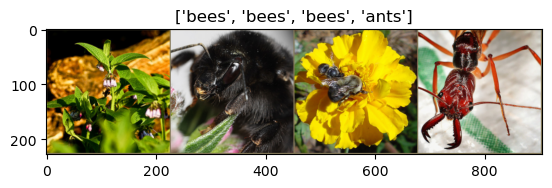

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0)) #H,W,C
    mean = np.array([0.485, 0.456, 0.406])
    #mean = np.array([0.5207, 0.4750, 0.3490])
    std = np.array([0.229, 0.224, 0.225])
    #std = np.array([0.2233, 0.2137, 0.2117])
    inp = inp * std + mean
    inp = np.clip(inp, 0, 1) # values smaller than 0 become 0, and values larger than 1 become 1. Equivalent to but faster than np.minimum(a_max, np.maximum(a, a_min)).
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001) # Wait a bit for plots to get updated

# Get a batch for training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epoch=25):
    since = time.time()

    # Create a temp dir to save the model checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)

        best_acc = 0.0
        for epoch in range (1, num_epoch+1):
            print(f"Epoch: {epoch}/{num_epoch}")
            print('-' * 50)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
            
                running_loss = 0.0
                running_correct = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device=device)
                    labels = labels.to(device=device)

                    optimizer.zero_grad()

                    # Enable gradient tracking in traing mode
                    with torch.set_grad_enabled(phase=='train'):
                        outputs = model(inputs)
                        _, pred = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # For train enable backward and optimizer
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                    running_loss    += loss.item() * inputs.size(0)
                    running_correct += torch.sum(pred == labels.data)
            
                if phase == 'train':
                    scheduler.step()
            
                epoch_loss = running_loss / dataset_sizes[phase]
                # epoch_acc  = running_correct.double() / dataset_sizes[phase] # double not supported in mac
                epoch_acc  = running_correct / dataset_sizes[phase]

                print(f"{phase} loss: {epoch_loss: .4f} accuracy: {epoch_acc: .4f}")

                # deep copy the model 
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f"Training Complete in {time_elapsed}")
        print(f"Best Accuracy : {best_acc: .4f}")

        # load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    
    return model

In [9]:
def visualize_model(model, num_images=6):
    set_to_train = model.training
    model.eval()
    image_count = 0
    #fig = plt.figure()

    with torch.no_grad():

        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            for j in range (inputs.size()[0]):
                image_count += 1
                ax = plt.subplot(3, 2, image_count)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_name[pred[j]]}')
                imshow(inputs.to(device='cpu')[j])

                if image_count == num_images:
                    model.train(mode=set_to_train)
                    return
        model.train(mode=set_to_train)        

In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

### Loss Function

Loss functions measure the difference between the predicted output and the actual target values. Common loss functions include Cross-Entropy Loss for classification tasks and Mean Squared Error for regression tasks.

### Optimizer

Optimizers are algorithms that adjust the model's parameters during training to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, and RMSprop.

### Scheduler

A scheduler adjusts the learning rate dynamically during training, allowing fine-tuning.

Cosine Annealing: The learning rate starts high and is annealed down to a minimum value following a cosine curve. It helps the model explore the search space broadly at the beginning of training and then refine the search space as it converges.

T_max: This parameter defines the total number of iterations it takes to complete one cycle of the cosine function. The learning rate will follow a cosine curve for the first T_max iterations and then restart the cycle.

Here's a conceptual explanation:

At the start of training, the learning rate is relatively high, allowing the model to explore a larger area of the loss landscape.
As training progresses (over the T_max iterations), the learning rate decreases following a cosine curve.
When T_max iterations are completed, the learning rate is at its minimum.
The scheduler then restarts the cosine curve, and the learning rate starts to increase again, allowing the model to explore broadly for the next cycle.
This approach often helps models converge more efficiently by first exploring broadly and then refining their parameters as training progresses.

In [11]:
num_in_ftrs = model_ft.fc.in_features
num_out_ftrs = NUM_OUT_FEATURES

model_ft.fc = nn.Linear(num_in_ftrs, num_out_ftrs)

model_ft = model_ft.to(device=device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epoch=NUM_EPOCH)

Epoch: 1/5
--------------------------------------------------
train loss:  0.6882 accuracy:  0.6352
val loss:  0.3224 accuracy:  0.8824
Epoch: 2/5
--------------------------------------------------
train loss:  0.6120 accuracy:  0.7746
val loss:  0.2718 accuracy:  0.8954
Epoch: 3/5
--------------------------------------------------
train loss:  0.5950 accuracy:  0.7828
val loss:  0.2501 accuracy:  0.8889
Epoch: 4/5
--------------------------------------------------
train loss:  0.7957 accuracy:  0.7377
val loss:  0.3471 accuracy:  0.8693
Epoch: 5/5
--------------------------------------------------
train loss:  0.8227 accuracy:  0.7049
val loss:  0.3870 accuracy:  0.8627
Training Complete in 229.17098808288574
Best Accuracy :  0.8954


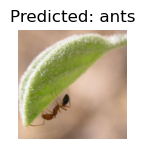

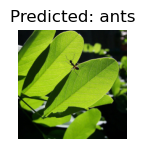

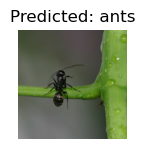

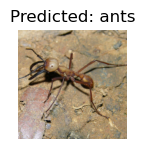

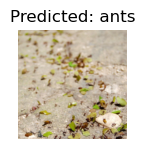

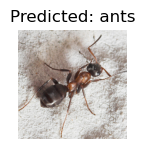

In [13]:
visualize_model(model_ft)

In [14]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

num_in_ftrs = model_conv.fc.in_features
num_out_ftrs = NUM_OUT_FEATURES

model_conv.fc = nn.Linear(num_in_ftrs, num_out_ftrs)

model_conv = model_conv.to(device=device)

criterion = nn.CrossEntropyLoss()

# opposed to before. Optimizer only on "fc" layer, unlike before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epoch=NUM_EPOCH)

Epoch: 1/5
--------------------------------------------------
train loss:  0.7839 accuracy:  0.5615
val loss:  0.2640 accuracy:  0.8889
Epoch: 2/5
--------------------------------------------------
train loss:  0.5168 accuracy:  0.7746
val loss:  0.1620 accuracy:  0.9477
Epoch: 3/5
--------------------------------------------------
train loss:  0.6292 accuracy:  0.7336
val loss:  0.1720 accuracy:  0.9477
Epoch: 4/5
--------------------------------------------------
train loss:  0.3935 accuracy:  0.8197
val loss:  0.1738 accuracy:  0.9542
Epoch: 5/5
--------------------------------------------------
train loss:  0.5408 accuracy:  0.7582
val loss:  0.2552 accuracy:  0.9020
Training Complete in 225.3013870716095
Best Accuracy :  0.9542


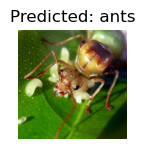

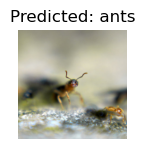

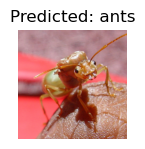

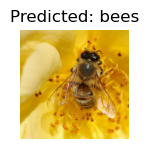

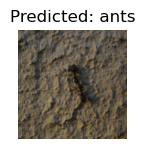

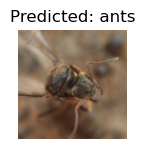

In [16]:
visualize_model(model_conv)

In [17]:
def visualize_model_image_file(model, image_path):
    set_to_train = model.training
    
    model.eval()
    img = Image.open(image_path)      # Image is in C x H x W format
    img = data_transforms['val'](img) 
    img = img.unsqueeze(0)            # Converts it to B x C x H x W format
    img = img.to(device=device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_name[pred[0]]}')
        imshow(img.to(device='cpu')[0])                     #Send one image at a time

        model.train(set_to_train)

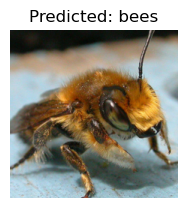

In [18]:
#image_path = '/Users/arindam/Machine Learning/ZIP_EXTRACT/hymenoptera_data/val/ants/800px-Meat_eater_ant_qeen_excavating_hole.jpg'
image_path = '/Users/arindam/Machine Learning/ZIP_EXTRACT/hymenoptera_data/train/bees/16838648_415acd9e3f.jpg'
model = model_ft
#model = model_conv

visualize_model_image_file(model, image_path)